Instructions

Get data
	Music21-corpus
		Corpus.getComposer('bach')
	Separate into voices
		Stream.elements gives you a list of different parts
	Break up into notes/rests
		Stream.flat.notesAndRests()
	Make two bigram matrices- rhythm, pitch, normalized pitch
		Rests have rhythm but pitch can just be 'Rest'
		For chords use .root()
		Normalized pitch:
			Normalize to the same key (transpose everything to one base key, say C Major/minor)
			Stream.analyze('key')
			Create interval between base key and stream key
Stream.transpose(interval)



In [1]:
import math
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import scipy.stats as stats
import utils
import h5py


In [2]:
duration_set = (0.125, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 6.0, 8.0, 12.0)
ds_encode_dict = {x:i for i,x in enumerate(duration_set)}
ds_decode_dict = {i:x for i,x in enumerate(duration_set)}

REST = 20

def encodeDuration(x):
    return ds_encode_dict[x]

def decodeDuration(x):
    return ds_decode_dict[x]

def encodeNote(x):
    return x - REST

def decodeNote(x):
    return x + REST
    
    

In [3]:
sorted([0.5, 1.0, 2.0, 3.0, 4.0, 6.0, 0.25, 8.0, 12.0, 0.125, 0.75, 1.5])

[0.125, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0, 6.0, 8.0, 12.0]

In [4]:
from music21 import corpus, converter,environment, midi, interval, pitch
from music21.stream import Stream
from music21.interval import GenericInterval
import numpy as np
us = environment.UserSettings()

try:
    us.create()
except:
    pass
# us['musescoreDirectPNGPath'] = "C:\\Program Files (x86)\\MuseScore 2\\bin\\MuseScore.exe"
# us['midiPath'] = '/usr/bin/timidity'


    #for i, piece in enumerate(pieces):
    #    score = converter.parse(piece)
    #    print(piece.split("/")[-1],i,[x.partName for x in score.parts])

    #print("DONE")
    #raise ValueError()





def frequenciesFromPieces(pieces, verbose=0):


    first_note_freq = [0] * 80
    first_duration_freq = [0] * len(duration_set) 
    note_transitions = np.zeros((80,80))
    duration_transitions = np.zeros((len(duration_set),len(duration_set)))



    for i, piece in enumerate(pieces):
        if(verbose): print(piece)
        score = converter.parse(piece)
        key = score.analyze('key')
        #print(rng)
        score_interval = interval.Interval(key.tonic,pitch.Pitch('C'))
        new_score = score.transpose(score_interval)
        flattened_score = new_score.flattenParts()#["Soprano"]
        #flattened_score = new_score["Alto"]
        #flattened_score.flat.notesAndRests.stream().show('text')
        prevNote = None
        prevDuration = None
        for x in flattened_score.flat.notesAndRests.stream():
            if(x.isChord):
                note_num = x.root().midi
            else:
                note_num = x.pitch.midi
            if(x.isRest):
                note_num = REST

            e_n = encodeNote(note_num)
            e_d = encodeDuration(x.duration.quarterLength)

            if(prevNote == None):
                first_note_freq[e_n] += 1
                first_duration_freq[e_d] += 1
            else:
                note_transitions[prevNote,e_n] += 1
                duration_transitions[prevDuration,e_d] += 1

            prevNote = e_n
            prevDuration = e_d
    return first_note_freq, first_duration_freq, note_transitions, duration_transitions

def writeHDF5(name,out):
    f = h5py.File(name, 'w')
    f.create_dataset('first_note_freq', data=out[0])
    f.create_dataset('first_duration_freq', data=out[1])
    f.create_dataset('note_transitions', data=out[2])
    f.create_dataset('duration_transitions', data=out[3])
    f.close()
    
def readHDF5(name):
    f = h5py.File(name, 'r')
    out = (f["first_note_freq"][:],
           f["first_duration_freq"][:],
           f["note_transitions"][:],
           f["duration_transitions"][:])
    f.close()
    return out

def selectSimplePieces(piece):
    score = converter.parse(piece)
    return set([x.partName for x in score.parts]) == set(['Soprano', 'Alto', 'Tenor', 'Bass'])
        
        #print(first_note_priors)
        #print(first_duration_priors)
        
        #print(note_transitions)
        #print(duration_transitions)
        
        #duration_set.add(x.duration.quarterLength)
        #note_set.add(note_num)
        #print(x.isChord,x.duration.quarterLength,x.name, x.pitch.diatonicNoteNum,x.isNote)
    #print(note_set)
    #print(duration_set)
    
    #sp = midi.realtime.StreamPlayer(part)
    #sp.play()
    #print(score.flat.elements)
    #print(type(score))
    #a = score.elements.encode('utf-8').strip()
    #print(score.flat.notesAndRests())
    #break
    #for e in score.parts:
        #e = e.flat.notesAndRests()
    #    sp = midi.realtime.StreamPlayer(e)
    #    sp.play()
        
        #print(unicode(e).encode('utf8'))
    #print(score.elements[2])
    #break
    #score.flat.notesAndRests()
    #print(score)
    #score.flat.show("midi")
    #if(i > 10):
    #    break

In [78]:
allBach = corpus.getComposer('bach')
out = frequenciesFromPieces(allBach,verbose=1)
writeHDF5('all_bach.h5', out)

simpleBach = list(filter(selectSimplePieces, allBach))
out = frequenciesFromPieces(simpleBach,verbose=1)
writeHDF5('simple_bach.h5', out)

print(len(simpleBach),len(allBach))



C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv1.6.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv10.7.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv101.7.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv102.7.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv103.6.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv104.6.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv108.6.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv11.6.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv110.7.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv111.6.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv112.5-sc.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv112.5.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-pac

C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.17.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.25.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.29-a.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.3.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.32.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.37.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.40.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.44.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.46.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.54.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.62.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv245.11.mxl
C:\Users\liget_4sn\Anaconda

C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv305.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv306.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv307.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv308.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv309.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv31.9.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv310.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv311.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv312.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv313.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv314.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv315.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\b

C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv40.3.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv40.6.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv40.8.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv400.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv401.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv402.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv403.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv404.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv405.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv406.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv407.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv408.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus

C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\choraleAnalyses\riemenschneider004.rntxt
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\choraleAnalyses\riemenschneider005.rntxt
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\choraleAnalyses\riemenschneider006.rntxt
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\choraleAnalyses\riemenschneider007.rntxt
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\choraleAnalyses\riemenschneider008.rntxt
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\choraleAnalyses\riemenschneider009.rntxt
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\choraleAnalyses\riemenschneider010.rntxt
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\choraleAnalyses\riemenschneider011.rntxt
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\choraleAnalyses\riemenschneider012.rntxt
C:\Users\liget_4sn\Anaconda3

C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv24.6.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.10.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.15.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.17.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.25.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.29-a.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.3.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.32.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.37.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.40.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.44.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv244.46.mxl
C:\Users\liget_4sn\Anaconda3\

C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv318.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv319.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv32.6.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv320.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv321.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv322.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv323.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv324.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv325.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv326.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv327.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv328.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\b

C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv412.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv413.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv414.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv415.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv416.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv417.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv418.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv419.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv42.7.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv420.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv421.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\bach\bwv422.mxl
C:\Users\liget_4sn\Anaconda3\Lib\site-packages\music21\corpus\b

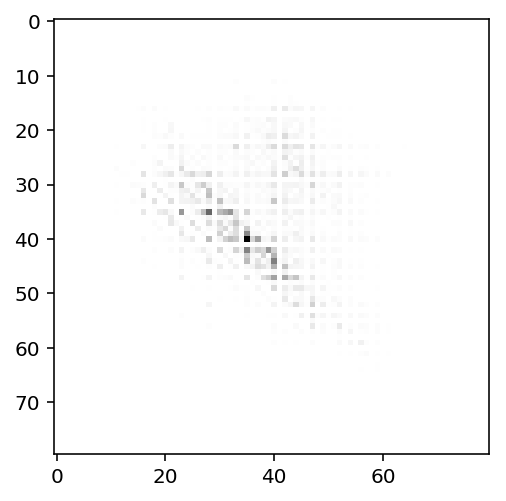

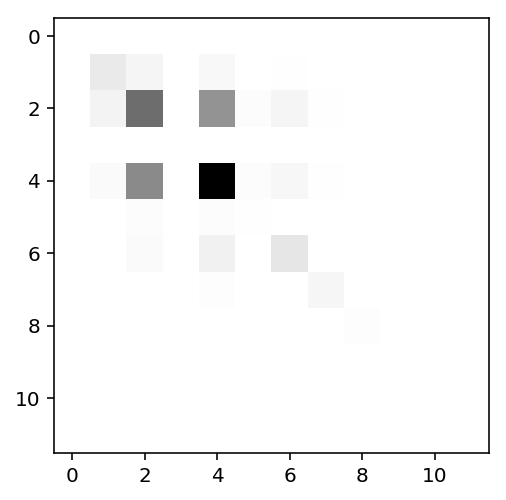

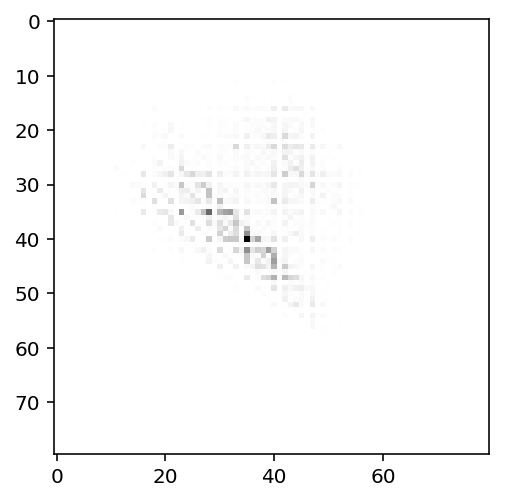

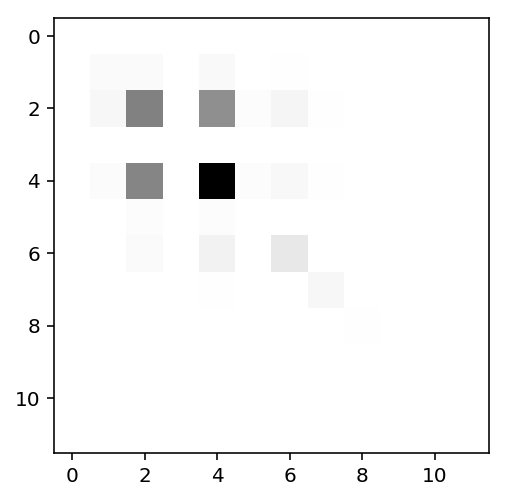

80


In [5]:
#f = h5py.File('all_bach.h5', 'r')
# np.unique(readHDF5('all_bach.h5')[2])
allBachMat = readHDF5('all_bach.h5')
simpleBachMat = readHDF5('simple_bach.h5')
_,_,allNote, allDuration =allBachMat
_,_,simpleNote, simpleDuration =simpleBachMat
plt.imshow(allNote, cmap='binary', interpolation='none')
plt.show()
plt.imshow(allDuration, cmap='binary', interpolation='none')   
plt.show()
plt.imshow(simpleNote, cmap='binary', interpolation='none')
plt.show()
plt.imshow(simpleDuration, cmap='binary', interpolation='none')   
plt.show()
print(len(allNote))

In [6]:
#heyperparameters
s_len =80
num_iter = 100000
epsilon = 1e-10
start_note = 25
end_note = 55

In [7]:
# print(allNote[34])
# allNote = allNote[25:55][25:55]
# simpleNote = simpleNote[25:55][25:55]
allNote[:start_note] = 0
allNote[end_note:] = 0

In [8]:
def metropolis_hastings(proposal_func, init_func, acceptance_score, num_iters, step=30):
    """
    Runs the metropolis-hastings algorithm for
    num_iters iterations, using proposal_func
    to generate samples and scorer to assign
    probability scores to samples.
      
    proposal_func -- function that proposes
        candidate state; takes in current state as
        argument and returns candidate state
    init_func -- function that proposes starting
        state; takes no arguments and returns a
        sample state
    acceptance_score -- function that calculates the acceptance
        probability; takes in two state samples
        (candidate first, then sample) and returns
        acceptance probability
    
    Returns a sequence of every step-th sample. You 
    should only sample on upon acceptance of a new
    proposal. Do not keep sampling the current state.
    
    Note the total number of samples will NOT be
    equal to num_iters. num_iters is the total number
    of proposals we generate.
    """
    samples = []
    sample = init_func()
    for i in range(num_iters):
        candidate = proposal_func(sample)
        score = acceptance_score(candidate,sample)
        acceptance_ratio = min(1, score)
#         print(score)
        if np.random.uniform() < acceptance_ratio:
            sample = candidate
            samples.append(sample)
#             print("Swapped")
#         else:
#             print("Rejected")
    return samples[::step]

In [9]:
def make_starting_state(freq_mat):
    def starting_state():
        nonlocal freq_mat
        prob = np.sum(freq_mat, axis=1)
        prob = prob/np.sum(prob)
        starting_ordering = np.random.choice(len(prob), s_len, p=prob)
        return starting_ordering
    return starting_state

# print(starting_state(allDuration))

def make_sample_candidate(isDuration=False):
    if isDuration:
        def sample_candidate(sample):
            """
            To search for new ciphers, randomly
            swap two letters in the previous cipher.
            """
            #swap durations
            to_swap = np.random.choice(s_len, 2)
            new_sample = np.copy(sample)
            new_sample[to_swap[0]], new_sample[to_swap[1]] = new_sample[to_swap[1]], sample[to_swap[0]]

            return new_sample
    else:
        def sample_candidate(sample):
            """
            To search for new ciphers, randomly
            swap two letters in the previous cipher.
            """
#             swap notes
            to_swap = np.random.choice(s_len, 2)
            new_sample = np.copy(sample)
            new_sample[to_swap[0]], new_sample[to_swap[1]] = new_sample[to_swap[1]], sample[to_swap[0]]

#             # sample new notes
#             to_swap = np.random.choice(s_len, 1)
#             new_note = np.random.randint(start_note, end_note)
#             new_sample = np.copy(sample)
#             new_sample[to_swap] = new_note

            return new_sample
        
    return sample_candidate

def make_acceptance_scorer(transition_matrix):
    """
    Calculate the acceptance probability, which is the
    probability of observing the message translated by
    the proposed cipher devided by the probability of
    obseving the message translated by the current
    cipher.
    """
    def scorer(candidate, sample):
        nonlocal transition_matrix
        candidate_log_likelihood = 0
        sample_log_likelihood = 0
        for i in range(len(candidate) - 1):
            c_first, c_second = candidate[i], candidate[i+1]
            candidate_log_likelihood += np.log(pow(transition_matrix[c_first][c_second],.5)+epsilon)
    
            s_first, s_second = sample[i], sample[i+1]
            sample_log_likelihood += np.log(pow(transition_matrix[s_first][s_second],.5)+epsilon)
        return np.exp(candidate_log_likelihood - sample_log_likelihood)
    return scorer

scorer = make_acceptance_scorer(allNote)
duration_scorer = make_acceptance_scorer(allDuration)
sample_candidate = make_sample_candidate()
duration_sample_candidate = make_sample_candidate(isDuration=True)

In [10]:
starting_state = make_starting_state(allNote)
samples = metropolis_hastings(sample_candidate, starting_state, scorer, num_iter)

In [11]:
duration_starting_state = make_starting_state(allDuration)
duration_samples = metropolis_hastings(duration_sample_candidate, duration_starting_state, duration_scorer, num_iter)

In [12]:
for sample in samples[-5:]:
    print(sample, '\n')

[32 39 30 52 30 40 28 44 30 42 47 45 52 43 31 26 33 31 47 31 40 33 42 47 40
 27 34 51 30 35 45 47 40 33 40 35 27 44 40 33 39 33 40 52 44 37 31 45 30 44
 40 32 35 45 26 47 38 33 39 33 42 27 45 39 47 39 47 28 33 26 45 40 50 54 47
 40 35 35 42 51] 

[33 39 30 31 30 40 28 45 30 40 47 45 26 43 31 33 33 52 47 30 40 33 31 35 44
 27 34 51 51 35 45 30 39 33 47 35 27 40 40 33 40 32 45 52 45 40 31 26 33 44
 40 32 35 44 52 47 38 33 39 44 42 27 47 39 47 39 47 26 28 40 42 42 50 54 45
 40 35 47 42 37] 

[33 26 30 45 30 30 50 45 30 31 45 31 39 43 38 33 33 52 47 40 42 42 40 35 47
 27 34 51 51 35 45 30 37 28 47 35 27 40 45 32 33 33 33 39 33 40 31 45 40 44
 40 32 35 44 52 47 31 33 39 44 54 27 47 52 47 39 47 26 28 26 42 42 40 44 40
 40 35 47 40 39] 

[33 31 30 27 40 30 50 45 42 33 33 35 39 43 38 45 40 52 40 45 42 42 40 35 47
 40 34 51 51 35 45 31 42 33 33 30 40 37 45 33 26 47 28 39 33 40 31 30 27 31
 40 32 26 54 52 47 44 32 39 44 39 30 47 40 47 44 47 35 28 26 45 47 52 44 47
 40 35 27 33 39] 

[47 31 42 47

In [13]:
for sample in duration_samples[-5:]:
    print(sample, '\n')

[4 4 4 4 4 4 2 6 6 4 4 4 2 2 2 4 4 5 4 4 4 4 4 4 4 2 2 2 4 4 2 4 4 4 2 5 4
 2 6 4 4 4 5 2 1 1 4 4 2 4 4 4 4 4 4 4 2 6 4 2 4 2 4 2 1 1 2 4 4 6 6 4 4 7
 4 4 2 2 2 1] 

[4 4 4 4 4 2 2 6 6 4 4 4 4 2 2 4 4 5 5 4 4 2 4 4 4 2 2 2 4 4 2 2 2 4 2 2 4
 4 6 4 4 4 4 4 1 1 4 4 4 4 4 4 4 4 4 4 4 6 5 2 4 2 2 2 1 1 2 4 4 6 6 4 4 7
 4 4 4 2 2 1] 

[2 6 4 4 4 2 2 4 6 4 4 4 4 2 2 4 4 5 5 4 4 4 4 6 4 4 2 4 4 4 4 2 2 4 4 4 4
 4 4 4 4 4 4 4 1 1 4 4 2 4 2 4 4 2 4 4 4 6 5 2 4 2 2 2 1 1 2 2 4 6 6 2 4 7
 4 4 4 2 2 1] 

[4 6 4 4 4 2 4 2 6 4 4 4 4 4 2 4 4 5 5 4 2 6 4 6 4 4 2 2 4 4 2 2 2 4 4 4 7
 4 4 4 2 2 4 4 4 4 4 4 2 4 4 4 4 2 1 4 4 4 5 4 4 2 2 2 1 1 2 4 4 6 6 4 4 1
 1 2 4 2 2 4] 

[4 6 6 4 4 4 2 2 2 4 4 4 4 4 4 4 4 7 5 4 2 4 2 6 4 4 2 2 4 4 4 2 2 4 4 4 5
 4 4 4 2 2 2 4 4 4 4 2 2 4 4 4 4 2 2 4 4 4 5 6 4 1 2 2 1 1 2 4 4 6 6 4 4 1
 1 4 4 4 2 4] 



In [17]:
print("====pitch====")

pitch_combined = [" ".join([str(x) for x in s]) for s in samples]
best_pitch_combined = max(set(pitch_combined),key=pitch_combined.count)
print(1.0 * len(best_pitch_combined) / num_iter)
best_pitch = [int(x) for x in best_pitch_combined.split()]
print(best_pitch)


print("====duration====")

duration_combined = [" ".join([str(x) for x in s]) for s in duration_samples]
best_duration_combined = max(set(duration_combined),key=duration_combined.count)
print(1.0 * len(best_duration_combined) / num_iter)
best_duration = [int(x) for x in best_duration_combined.split()]
print(best_duration)

====pitch====
0.00239
[39, 40, 40, 30, 47, 39, 35, 47, 52, 47, 39, 40, 28, 31, 26, 42, 27, 47, 40, 32, 28, 42, 33, 52, 45, 40, 33, 51, 47, 44, 35, 27, 45, 33, 30, 39, 44, 34, 47, 38, 35, 31, 51, 40, 35, 31, 43, 40, 31, 45, 40, 37, 30, 26, 26, 44, 40, 33, 40, 39, 42, 33, 44, 45, 30, 47, 47, 27, 45, 42, 33, 33, 35, 32, 33, 45, 54, 30, 52, 50]
====duration====
0.00159
[2, 4, 4, 4, 5, 5, 5, 6, 2, 2, 2, 4, 4, 4, 2, 4, 6, 4, 4, 2, 4, 4, 4, 4, 6, 2, 4, 4, 4, 4, 2, 4, 2, 4, 4, 2, 2, 1, 1, 2, 2, 4, 1, 4, 2, 4, 4, 4, 2, 4, 4, 4, 2, 6, 7, 4, 4, 2, 1, 1, 4, 4, 4, 6, 4, 6, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2]


In [18]:
from music21.note import Note, Rest
from music21.stream import Stream
# print(best_pitch)
def makeSong(durations, pitches):
    songStream = Stream()
    print(pitches)
    print(durations)
    
    for i in range(len(durations)):
        curDuration = durations.pop(0)
        curDuration = decodeDuration(curDuration)
        curPitch = pitches.pop(0)
        curPitch = decodeNote(curPitch)
        if(curPitch == REST):
            songStream.append(Rest(curDuration))
        else:
            curNote = Note()
            curNote.pitch.midi = curPitch
            curNote.duration.quarterLength = curDuration
            songStream.append(curNote)
    songStream.show('midi')
    songStream.show()

# makeSong([2]*s_len, list(samples[1]))
makeSong(best_duration, best_pitch)

[39, 40, 40, 30, 47, 39, 35, 47, 52, 47, 39, 40, 28, 31, 26, 42, 27, 47, 40, 32, 28, 42, 33, 52, 45, 40, 33, 51, 47, 44, 35, 27, 45, 33, 30, 39, 44, 34, 47, 38, 35, 31, 51, 40, 35, 31, 43, 40, 31, 45, 40, 37, 30, 26, 26, 44, 40, 33, 40, 39, 42, 33, 44, 45, 30, 47, 47, 27, 45, 42, 33, 33, 35, 32, 33, 45, 54, 30, 52, 50]
[2, 4, 4, 4, 5, 5, 5, 6, 2, 2, 2, 4, 4, 4, 2, 4, 6, 4, 4, 2, 4, 4, 4, 4, 6, 2, 4, 4, 4, 4, 2, 4, 2, 4, 4, 2, 2, 1, 1, 2, 2, 4, 1, 4, 2, 4, 4, 4, 2, 4, 4, 4, 2, 6, 7, 4, 4, 2, 1, 1, 4, 4, 4, 6, 4, 6, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2]


SubConverterException: To create PNG files directly from MusicXML you need to download MuseScore and put a link to it in your .music21rc via Environment.